<a target="_blank" href="https://colab.research.google.com/github/felixp8/text-to-nn/blob/main/experiments/mlp/classifier/classifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [62]:
!pip install lightning

In [2]:
!git clone https://github.com/felixp8/text-to-nn.git

Cloning into 'text-to-nn'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 152 (delta 14), reused 20 (delta 5), pack-reused 106
Receiving objects: 100% (152/152), 61.83 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (26/26), done.


In [3]:
import os

os.chdir("./text-to-nn/experiments/mlp/data_generation")

In [4]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import h5py

In [5]:
from expr_utils import map_inputs, clean_expr

In [49]:
expression_file = "./data/tiny/expressions.csv"
parameter_file = "./data/tiny/parameters.h5"

expr_csv = pd.read_csv(expression_file)
with h5py.File(parameter_file, 'r') as h5f:
    parameters = h5f['nn_parameters'][:h5f['counter'][()].item(), :]

assert expr_csv.shape[0] == parameters.shape[0]

In [50]:
mult_mask = np.array(['*' in expr for expr in expr_csv['expr']])

expr_csv = expr_csv[~mult_mask]
parameters = parameters[~mult_mask]

In [51]:
expr_list = expr_csv['expr']
expr_list = [map_inputs(expr, 3, ['x', 'y', 'z']) for expr in expr_list]
expr_list = [clean_expr(expr) for expr in expr_list]
expr_list = [str(sp.parsing.sympy_parser.parse_expr(expr, evaluate=False)) for expr in expr_list]

In [52]:
le = LabelEncoder()
classes = le.fit_transform(expr_list)
num_classes = len(np.unique(classes))

In [ ]:
# ss = StandardScaler()
# parameters_scaled = ss.fit_transform(parameters)

1269
1307


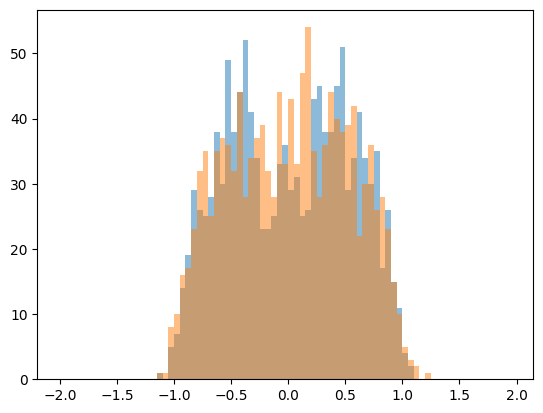

In [53]:
for i in range(2):
    mask = classes == i
    plt.hist(parameters[mask][:, 2], bins=np.arange(-2., 2., 0.05), alpha=0.5)
    print(mask.sum())

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [55]:
from model import MLP

In [56]:
inputs = torch.from_numpy(parameters)
targets = torch.from_numpy(classes)

dataset = torch.utils.data.TensorDataset(inputs, targets)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])

num_train = len(train_dataset)
num_valid = len(valid_dataset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

In [58]:
num_epochs = 400
lr = 1e-3
device = 'cpu'
log_every_n_epochs = 10

model = MLP(
    input_dim=65, # 353,
    hidden_dims=[32, 32,],
    output_dim=num_classes,
    activation='relu',
    dropout=0.3,
)

model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
for n in range(num_epochs):
    model.train()
    mean_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        mean_train_loss += loss.item() * x.shape[0] / num_train
    if (n % log_every_n_epochs == 0) or (n == num_epochs - 1):
        model.eval()
        mean_valid_loss = 0
        mean_valid_accuracy = 0
        for batch in valid_dataloader:
            with torch.no_grad():
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = F.cross_entropy(y_pred, y)
                accuracy = (y_pred.argmax(dim=-1) == y).sum() / len(y)
                mean_valid_loss += loss.item() * x.shape[0] / num_valid
                mean_valid_accuracy += accuracy.item() * x.shape[0] / num_valid
        print(
            f"Epoch {n:04d}: train loss = {mean_train_loss:.4f}, "
            f"valid loss = {mean_valid_loss:.4f}, "
            f"valid accuracy = {mean_valid_accuracy:.4f}"
        )

Epoch 0000: train loss = 2.0837, valid loss = 2.0853, valid accuracy = 0.1150
Epoch 0010: train loss = 1.8731, valid loss = 1.8251, valid accuracy = 0.3537
Epoch 0020: train loss = 1.2779, valid loss = 1.0595, valid accuracy = 0.7117
Epoch 0030: train loss = 1.0477, valid loss = 0.7679, valid accuracy = 0.8150
Epoch 0040: train loss = 0.9777, valid loss = 0.6615, valid accuracy = 0.8363
Epoch 0050: train loss = 0.9357, valid loss = 0.5971, valid accuracy = 0.8583
Epoch 0060: train loss = 0.8863, valid loss = 0.5584, valid accuracy = 0.8627
Epoch 0070: train loss = 0.8676, valid loss = 0.5236, valid accuracy = 0.8740
Epoch 0080: train loss = 0.8164, valid loss = 0.4982, valid accuracy = 0.8823
Epoch 0090: train loss = 0.8080, valid loss = 0.4779, valid accuracy = 0.8867
Epoch 0100: train loss = 0.7802, valid loss = 0.4605, valid accuracy = 0.8870
Epoch 0110: train loss = 0.7898, valid loss = 0.4481, valid accuracy = 0.8873
Epoch 0120: train loss = 0.7591, valid loss = 0.4377, valid accu

In [59]:
model.eval()
y_pred_all = []
y_all = []
for batch in valid_dataloader:
    with torch.no_grad():
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        y_pred_all.append(y_pred.argmax(dim=-1).numpy())
        y_all.append(y.numpy())
model.train()

y_pred_all = np.concatenate(y_pred_all)
y_all = np.concatenate(y_all)

In [60]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_all, y_pred_all)

array([[309,  38,  18,   4,   0,   0,   0,   0],
       [ 34, 334,   3,   2,   0,   1,   0,  30],
       [ 23,   0, 330,  26,   0,   0,   0,   0],
       [  0,   0,  12, 347,   3,   0,  31,   0],
       [  0,   0,   0,   2, 318,  33,  23,   0],
       [  0,   0,   0,   0,  16, 322,   0,  16],
       [  0,   0,   0,  16,  14,   0, 315,   0],
       [  1,  18,   0,   0,   0,  16,   0, 345]])

In [61]:
le.classes_

array(['-x', '-x + y', '-x - y', '-y', 'x', 'x + y', 'x - y', 'y'],
      dtype='<U6')